In [4]:
import xarray as xr
import pandas as pd
import numpy as np
from typing import List

TIMESTEP="6H"


def update_longitude(ds: xr.Dataset) -> xr.Dataset:
    if "lon" not in ds.variables:
        ds = ds.rename({"latitude": "lat", "longitude": "lon"})
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    ds.lon.attrs['units'] = "degrees_east"
    ds.lon.attrs['long_name'] = "longitude"
    ds.lon.attrs['standard_name'] = "longitude"
    return ds


def find_nearest_idx(
    arr1: np.ndarray, arr2: np.ndarray, val1: float, val2: float,
) -> int:
    """Find first nearest index for a given tolerance for two arrays and 2 values

    :param arr1: first array
    :param arr2: second arrat
    :param val1: value to find in first array
    :param val2: value to find in second array
    :return: index as int
    """
    try:
        idx = (np.abs(arr1 - val1) + np.abs(arr2 - val2)).argmin()
    except:
        idx = 0
    return idx


da_clim = update_longitude(xr.open_dataset("/home/daep/projects/ec_land_db/ec_land_db/scratch/surfclim_399_l4", engine="netcdf4", decode_times=False)).compute()
da_clim

<xarray.Dataset>
Dimensions:    (x: 187070, month: 12)
Coordinates:
    lat        (x) float64 83.54 83.54 83.54 83.54 ... -89.83 -89.83 -89.83
    lon        (x) float64 -35.45 -32.73 -30.0 -27.27 ... -54.0 -36.0 -18.0
  * x          (x) int32 2192 2193 2194 2195 ... 654397 654398 654399 654400
  * month      (month) float32 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
Data variables: (12/24)
    cell_area  (x) float64 8.537e+08 8.537e+08 8.537e+08 ... 1.477e+08 1.477e+08
    Malbedo    (month, x) float32 0.15 0.15 0.15 0.15 ... 0.15 0.15 0.15 0.15
    Mlail      (month, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Mlaih      (month, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    fwet       (month, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Mask       (x) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1 1
    ...         ...
    seaice     (x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    LDEPTH     (x) float32 29.28 24.26 32.51 66.78 24.48 ... 10.0 10.0 10.0 10.0
    CLAKE      (x) float32 5.114e-05 0.0001599 0.0009423 0.0 ... 0.0 0.0 0.0 0.0
    cu         (x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    Ctype      (x) float32 3.0 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0 3.0 3.0
    glm        (x) float32 0.3333 0.1256 0.08334 0.1105 ... 1.0 1.0 1.0 1.0
Attributes:
    history:  Created Fri Oct 13 10:06:00 2023based onsurfclim_all

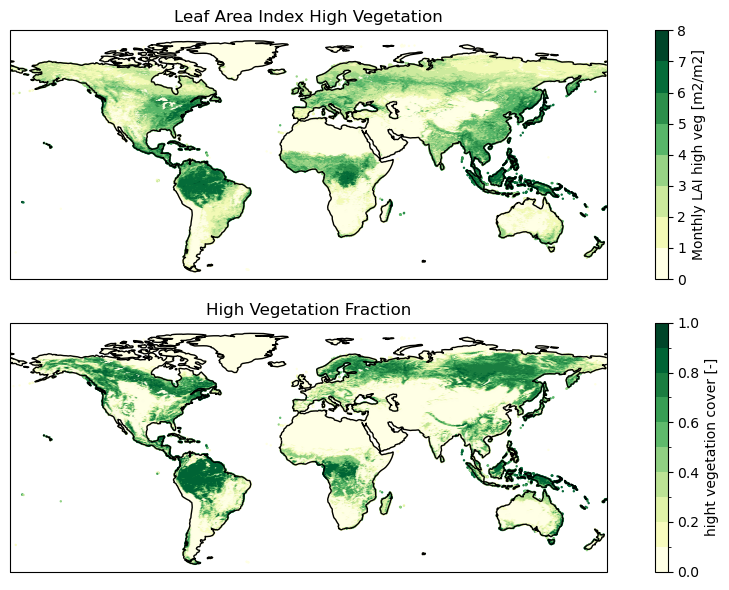

In [5]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

PROJ=ccrs.PlateCarree()
fig = plt.figure(figsize=(10,6),)
ax1 = plt.subplot(211, projection=PROJ)
ax2 = plt.subplot(212, projection=PROJ)
ax1.coastlines()
ax2.coastlines()
ax1.set_extent((-180, 180, -60, 90), crs=PROJ)
ax2.set_extent((-180, 180, -60, 90), crs=PROJ)

da_clim.isel(month=7).plot.scatter(x="lon", y="lat", hue="Mlaih", 
                                         add_colorbar=True, hue_style="discrete", 
                                         edgecolor=None, 
                                         s=0.5,
                                         levels=9,
                                         cmap="YlGn",
                                         ax=ax1
                                         #cbar_kwargs={"extend": "both"}
                                        )

da_clim.isel(month=7).plot.scatter(x="lon", y="lat", hue="cvh", 
                                         add_colorbar=True, hue_style="discrete", 
                                         edgecolor=None, 
                                         s=0.5,
                                         levels=11,
                                         cmap="YlGn",
                                         ax=ax2
                                         #cbar_kwargs={"extend": "both"}
                                        )

ax1.set_title("Leaf Area Index High Vegetation")
ax2.set_title("High Vegetation Fraction")
fig.tight_layout()
# fig.savefig("lai_cvh.png", bbox_inches="tight")

In [8]:
da_fc = xr.open_mfdataset("/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_fc_*.grb", 
                       engine="cfgrib", 
                       combine="nested", 
                       backend_kwargs={'filter_by_keys':{'edition': 1}},
                       )
drop_lst = list(da_fc.drop(["latitude", "longitude", "step"]).coords)
time_arr = da_fc.valid_time.values
da_fc = da_fc.drop(drop_lst).rename({"step": "time", "values": "x"}).isel(x=da_clim.x.values-1)
da_fc["time"] = time_arr
da_fc = update_longitude(da_fc.isel(time=slice(0,-1))).resample(time=TIMESTEP).mean()
# da_fc = update_longitude(da_fc.resample(time=TIMESTEP, closed="right").mean()
da_fc

<xarray.Dataset>
Dimensions:  (x: 187070, time: 124)
Coordinates:
    lat      (x) float64 dask.array<chunksize=(187070,), meta=np.ndarray>
    lon      (x) float64 dask.array<chunksize=(187070,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-01-31T18:00:00
Dimensions without coordinates: x
Data variables:
    t2m      (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    d2m      (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    e        (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    fal      (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    lai_lv   (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    lai_hv   (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    sro      (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    aco2gpp  (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    ssro     (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-10-25T19:56 GRIB to CDM+CF via cfgrib-0.9.1...

In [22]:
da = xr.open_dataset("/ec/res4/scratch/daep/ec_training_db_out/i6aj_20181201_snow_238.grb", engine="cfgrib").isel(time=slice(0, 2), values=slice(13310,13312))
da

<xarray.Dataset>
Dimensions:     (time: 2, snowLayer: 2, values: 2)
Coordinates:
  * time        (time) datetime64[ns] 2018-12-01 2018-12-01T01:00:00
    step        timedelta64[ns] ...
  * snowLayer   (snowLayer) float64 1.0 2.0
    latitude    (values) float64 ...
    longitude   (values) float64 ...
    valid_time  (time) datetime64[ns] ...
Dimensions without coordinates: values
Data variables:
    tsn         (time, snowLayer, values) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-10-27T14:08 GRIB to CDM+CF via cfgrib-0.9.1...

In [23]:
print(da.compute())

<xarray.Dataset>
Dimensions:     (time: 2, snowLayer: 2, values: 2)
Coordinates:
  * time        (time) datetime64[ns] 2018-12-01 2018-12-01T01:00:00
    step        timedelta64[ns] 00:00:00
  * snowLayer   (snowLayer) float64 1.0 2.0
    latitude    (values) float64 72.52 72.52
    longitude   (values) float64 72.44 73.54
    valid_time  (time) datetime64[ns] 2018-12-01 2018-12-01T01:00:00
Dimensions without coordinates: values
Data variables:
    tsn         (time, snowLayer, values) float32 235.6 nan 249.7 ... 249.5 nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-10-27T14:08 GRIB to CDM+CF via cfgrib-0.9.1...


In [29]:
list(da_fc.drop(["latitude", "longitude", "step"]).coords)

['number', 'time', 'surface', 'valid_time']

In [17]:
da_fc.ssro.GRIB_dataType

'fc'

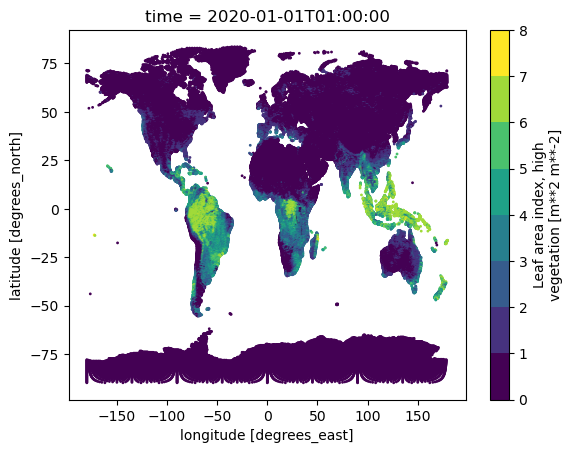

In [4]:
da_fc.isel(time=0).plot.scatter(x="lon", y="lat", hue="lai_hv", add_colorbar=True, hue_style="continuous", edgecolor=None, s=1, levels=9)

In [108]:
da_soil = xr.open_mfdataset("/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_soil_*.grb", 
                            engine="cfgrib", 
                            #combine="nested", 
                            compat="override",  
                            backend_kwargs={'filter_by_keys':{'edition': 1}})
da_soil = update_longitude(da_soil.drop(["number", "surface", "depthBelowLandLayer", "valid_time", "step"]).rename({"values": "x"}).isel(x=da_clim.x.values-1)).resample(time=TIMESTEP, closed="left").mean()
da_soil  # [sorted(da_soil.variables)]

<xarray.Dataset>
Dimensions:  (x: 187070, time: 124)
Coordinates:
    lat      (x) float64 dask.array<chunksize=(187070,), meta=np.ndarray>
    lon      (x) float64 dask.array<chunksize=(187070,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-01-31T18:00:00
Dimensions without coordinates: x
Data variables: (12/13)
    asn      (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    rsn      (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    sd       (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    skt      (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    stl1     (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    stl2     (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    ...       ...
    stl4     (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    swvl1    (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    swvl2    (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    swvl3    (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    swvl4    (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    tsn      (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-10-24T16:40 GRIB to CDM+CF via cfgrib-0.9.1...

: 

In [105]:
import grib2zarr
import imp
imp.reload(grib2zarr)

grib2zarr.open_grib_an("/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_soil_*.grb", da_clim.x.values-1, TIMESTEP)

<xarray.Dataset>
Dimensions:  (x: 187070, time: 124)
Coordinates:
    lat      (x) float64 dask.array<chunksize=(187070,), meta=np.ndarray>
    lon      (x) float64 dask.array<chunksize=(187070,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-01-31T18:00:00
Dimensions without coordinates: x
Data variables: (12/13)
    stl1     (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    sd       (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    stl2     (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    stl3     (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    skt      (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    stl4     (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    ...       ...
    asn      (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    rsn      (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    swvl1    (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    swvl2    (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    swvl3    (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    swvl4    (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-10-24T16:33 GRIB to CDM+CF via cfgrib-0.9.1...

In [91]:
da_snow = xr.open_mfdataset("/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_snow_*.grb", engine="cfgrib")
datavars_lst = list(da_snow.data_vars)
for layer in da_snow.snowLayer.values:
    for var in datavars_lst:
        da_snow[f"{var}_l{int(layer)}"] = da_snow[var].sel({"snowLayer": int(layer)})
da_snow = da_snow.drop(datavars_lst)
da_snow = update_longitude(da_snow.drop(["step", "valid_time", "snowLayer"]).rename({"values": "x"}).isel(x=da_clim.x.values-1)).resample(time=TIMESTEP, closed="left").mean()
da_snow[sorted(da_snow.data_vars)]

<xarray.Dataset>
Dimensions:  (time: 124, x: 187070)
Coordinates:
    lat      (x) float64 dask.array<chunksize=(187070,), meta=np.ndarray>
    lon      (x) float64 dask.array<chunksize=(187070,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-01-31T18:00:00
Dimensions without coordinates: x
Data variables: (12/20)
    lwcs_l1  (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    lwcs_l2  (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    lwcs_l3  (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    lwcs_l4  (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    lwcs_l5  (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    rsn_l1   (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    ...       ...
    sd_l5    (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    tsn_l1   (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    tsn_l2   (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    tsn_l3   (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    tsn_l4   (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    tsn_l5   (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-10-24T16:27 GRIB to CDM+CF via cfgrib-0.9.1...

In [106]:
grib2zarr.open_grib_an("/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_snow_*.grb", da_clim.x.values-1, TIMESTEP)

<xarray.Dataset>
Dimensions:  (x: 187070, time: 124)
Coordinates:
    lat      (x) float64 dask.array<chunksize=(187070,), meta=np.ndarray>
    lon      (x) float64 dask.array<chunksize=(187070,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-01-31T18:00:00
Dimensions without coordinates: x
Data variables: (12/20)
    lwcs_l1  (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    sd_l1    (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    tsn_l1   (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    rsn_l1   (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    lwcs_l2  (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    sd_l2    (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    ...       ...
    tsn_l4   (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    rsn_l4   (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    lwcs_l5  (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    sd_l5    (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    tsn_l5   (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
    rsn_l5   (time, x) float32 dask.array<chunksize=(1, 187070), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-10-24T16:33 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
da_clim

<xarray.Dataset>
Dimensions:    (x: 187070, month: 12)
Coordinates:
    lat        (x) float64 ...
    lon        (x) float64 -35.45 -32.73 -30.0 -27.27 ... -54.0 -36.0 -18.0
  * x          (x) int32 2192 2193 2194 2195 ... 654397 654398 654399 654400
  * month      (month) float32 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
Data variables: (12/24)
    cell_area  (x) float64 ...
    Malbedo    (month, x) float32 ...
    Mlail      (month, x) float32 ...
    Mlaih      (month, x) float32 ...
    fwet       (month, x) float32 ...
    Mask       (x) int32 ...
    ...         ...
    seaice     (x) float32 ...
    LDEPTH     (x) float32 ...
    CLAKE      (x) float32 ...
    cu         (x) float32 ...
    Ctype      (x) float32 ...
    glm        (x) float32 ...
Attributes:
    history:  Created Fri Oct 13 10:06:00 2023based onsurfclim_all

In [36]:
clim_feats = ["z0m", "geopot", "cvl", "cvh", "tvl", "tvh", "sotype", "sdor", "sdfor", "cu", "Ctype", "CLAKE"]
da_climfeats = da_clim.drop(["lat", "lon"])[clim_feats]
da_climfeats = da_climfeats.rename({x: f"0clim_{x}" for x in da_climfeats.data_vars}).expand_dims(dim={"time": da_fc.time})

In [6]:
da_model = xr.merge([da_fc, da_soil, da_snow, da_climfeats])
da_model = da_model[sorted(da_model.variables)].chunk({"x": -1, "time": -1})
#da_model.to_array().chunk({"x": -1, "variable": -1, "time": 2})
da_model

NameError: name 'da_fc' is not defined

In [4]:
import xarray as xr
da = xr.open_mfdataset("/ec/res4/scratch/daep/ec_training_db_out/*20100200.nc", engine="netcdf4", combine="nested")
da = update_longitude(da.set_coords(["lat", "lon"])).isel(time=slice(0,-1))#.resample(time=TIMESTEP).mean()
da

<xarray.Dataset>
Dimensions:  (x: 187070, time: 672)
Coordinates:
  * x        (x) int32 2192 2193 2194 2195 2326 ... 654397 654398 654399 654400
    lat      (x) float32 dask.array<chunksize=(187070,), meta=np.ndarray>
    lon      (x) float32 dask.array<chunksize=(187070,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2010-02-01 ... 2010-02-28T23:00:00
Data variables:
    Ctpf     (time, x) float32 dask.array<chunksize=(672, 187070), meta=np.ndarray>
    LWdown   (time, x) float32 dask.array<chunksize=(672, 187070), meta=np.ndarray>
    PSurf    (time, x) float32 dask.array<chunksize=(672, 187070), meta=np.ndarray>
    Qair     (time, x) float32 dask.array<chunksize=(672, 187070), meta=np.ndarray>
    Rainf    (time, x) float32 dask.array<chunksize=(672, 187070), meta=np.ndarray>
    SWdown   (time, x) float32 dask.array<chunksize=(672, 187070), meta=np.ndarray>
    Snowf    (time, x) float32 dask.array<chunksize=(672, 187070), meta=np.ndarray>
    Tair     (time, x) float32 dask.array<chunksize=(672, 187070), meta=np.ndarray>
    Wind_E   (time, x) float32 dask.array<chunksize=(672, 187070), meta=np.ndarray>
    Wind_N   (time, x) float32 dask.array<chunksize=(672, 187070), meta=np.ndarray>
Attributes:
    SOURCE:       ECMWF
    GRID_POINTS:  gaussian grid 
    CONVERTED:     from grib files with grib_api

In [11]:
da = xr.open_mfdataset("/ec/res4/scratch/daep/ec_training_db_out/20100200/test.nc", combine="nested")
da

<xarray.Dataset>
Dimensions:         (time: 673, reduced_points: 800, lat: 800, rgrid: 654400)
Coordinates:
  * time            (time) datetime64[ns] 2010-02-01 ... 2010-03-01
  * reduced_points  (reduced_points) int32 20 24 28 32 36 40 ... 36 32 28 24 20
  * lat             (lat) float64 89.83 89.6 89.38 89.16 ... -89.38 -89.6 -89.83
Dimensions without coordinates: rgrid
Data variables:
    var143          (time, rgrid) float32 dask.array<chunksize=(673, 654400), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Thu Oct 26 08:23:13 2023: cdo -f nc copy Rainf_20100200.grb...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [45]:
da = xr.open_mfdataset("/ec/res4/scratch/daep/ec_training_db_out/20100200/Rainf*.grb", engine="cfgrib", combine="nested").copy()
da

idx = find_nearest_idx(da.latitude.values, da.longitude.values, 51.5, 7.3)

times = np.array([time+da.step.values for time in da.time.values]).flatten()
da = da.rename({"time": "ini_time"})
da = da.stack(time=["ini_time", "step"])
da = da.drop(["time", "step", "ini_time"])
da["time"] = times
da

Ignoring index file '/ec/res4/scratch/daep/ec_training_db_out/20100200/Rainf_20100200.grb.923a8.idx' older than GRIB file


<xarray.Dataset>
Dimensions:     (values: 654400, time: 684)
Coordinates:
    number      int64 ...
    surface     float64 ...
    latitude    (values) float64 dask.array<chunksize=(654400,), meta=np.ndarray>
    longitude   (values) float64 dask.array<chunksize=(654400,), meta=np.ndarray>
    valid_time  (time) datetime64[ns] dask.array<chunksize=(684,), meta=np.ndarray>
  * time        (time) datetime64[ns] 2010-01-31T19:00:00 ... 2010-03-01T06:0...
Dimensions without coordinates: values
Data variables:
    cp          (values, time) float32 dask.array<chunksize=(654400, 684), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-10-26T09:05 GRIB to CDM+CF via cfgrib-0.9.1...

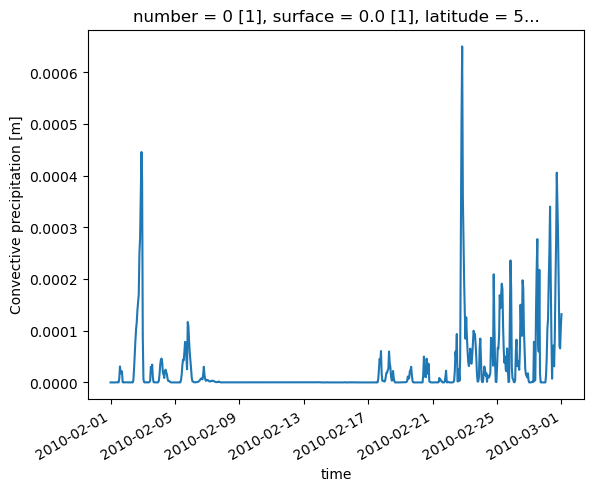

In [47]:
da.isel(values=idx).cp.plot()

In [4]:
da = xr.open_zarr("/ec/res4/scratch/daep/ec_training_db_out/ecland_eraforcing_20100200.zarr",)
da

<xarray.Dataset>
Dimensions:  (time: 112, x: 187070)
Coordinates:
    lat      (x) float32 dask.array<chunksize=(187070,), meta=np.ndarray>
    lon      (x) float32 dask.array<chunksize=(187070,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2010-02-01 ... 2010-02-28T18:00:00
  * x        (x) int32 2192 2193 2194 2195 2326 ... 654397 654398 654399 654400
Data variables:
    Ctpf     (time, x) float32 dask.array<chunksize=(112, 187070), meta=np.ndarray>
    LWdown   (time, x) float32 dask.array<chunksize=(112, 187070), meta=np.ndarray>
    PSurf    (time, x) float32 dask.array<chunksize=(112, 187070), meta=np.ndarray>
    Qair     (time, x) float32 dask.array<chunksize=(112, 187070), meta=np.ndarray>
    Rainf    (time, x) float32 dask.array<chunksize=(112, 187070), meta=np.ndarray>
    SWdown   (time, x) float32 dask.array<chunksize=(112, 187070), meta=np.ndarray>
    Snowf    (time, x) float32 dask.array<chunksize=(112, 187070), meta=np.ndarray>
    Tair     (time, x) float32 dask.array<chunksize=(112, 187070), meta=np.ndarray>
    Wind_E   (time, x) float32 dask.array<chunksize=(112, 187070), meta=np.ndarray>
    Wind_N   (time, x) float32 dask.array<chunksize=(112, 187070), meta=np.ndarray>
Attributes:
    CONVERTED:     from grib files with grib_api
    GRID_POINTS:  gaussian grid 
    SOURCE:       ECMWF

In [23]:
import cf2cdm
import cfgrib
a = cfgrib.open_dataset("/ec/res4/scratch/daep/ec_training_db_out/Rainf_20100200.nc")
#cf2cdm.translate_coords(da, cf2cdm.CDS)
a

Ignoring index file '/ec/res4/scratch/daep/ec_training_db_out/20100200/Rainf_20100200.grb.923a8.idx' older than GRIB file


<xarray.Dataset>
Dimensions:     (time: 57, step: 12, values: 654400)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2010-01-31T18:00:00 ... 2010-02-28T18:0...
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 11:00:00 12:00:00
    surface     float64 ...
    latitude    (values) float64 ...
    longitude   (values) float64 ...
    valid_time  (time, step) datetime64[ns] ...
Dimensions without coordinates: values
Data variables:
    cp          (time, step, values) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-10-26T08:46 GRIB to CDM+CF via cfgrib-0.9.1...

In [16]:
#da = da.rename({"time": "ini_time"}).stack(time=["ini_time", "step"])
a = np.array([time[0]+time[1] for time in da.time.values])
len(a)

684

In [18]:
da
da

<xarray.Dataset>
Dimensions:     (values: 542080, time: 684)
Coordinates:
    number      int64 ...
    surface     float64 ...
    latitude    (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    longitude   (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    valid_time  (time) datetime64[ns] dask.array<chunksize=(684,), meta=np.ndarray>
  * time        (time) object MultiIndex
  * ini_time    (time) datetime64[ns] 2010-01-31T18:00:00 ... 2010-02-28T18:0...
  * step        (time) timedelta64[ns] 01:00:00 02:00:00 ... 11:00:00 12:00:00
Dimensions without coordinates: values
Data variables:
    cp          (values, time) float32 dask.array<chunksize=(542080, 684), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-10-26T08:30 GRIB to CDM+CF via cfgrib-0.9.1...

In [19]:
import cf2cdm

In [7]:
da.to_array().chunk({"time":2, "x": -1, "variable": -1})

<xarray.DataArray (variable: 10, time: 124, x: 187070)>
dask.array<rechunk-merge, shape=(10, 124, 187070), dtype=float32, chunksize=(10, 2, 187070), chunktype=numpy.ndarray>
Coordinates:
  * x         (x) int32 2192 2193 2194 2195 2326 ... 654397 654398 654399 654400
    lat       (x) float32 dask.array<chunksize=(187070,), meta=np.ndarray>
    lon       (x) float32 dask.array<chunksize=(187070,), meta=np.ndarray>
  * time      (time) datetime64[ns] 2010-01-01 ... 2010-01-31T18:00:00
  * variable  (variable) object 'Ctpf' 'LWdown' 'PSurf' ... 'Wind_E' 'Wind_N'
Attributes:
    SOURCE:       ECMWF
    GRID_POINTS:  gaussian grid 
    CONVERTED:     from grib files with grib_api

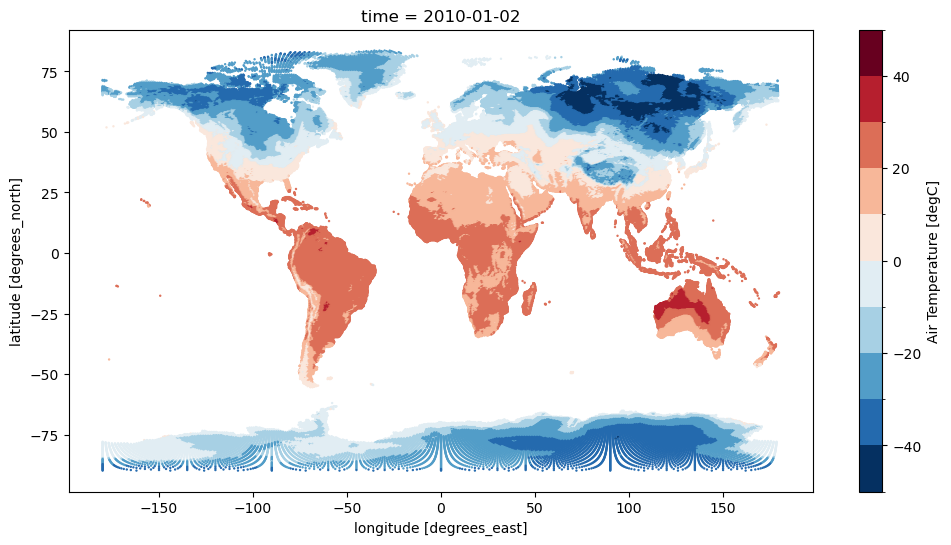

In [14]:
(da.isel(time=24)-273.15).plot.scatter(x="lon", y="lat", hue="Tair", 
                                         add_colorbar=True, hue_style="continuous", 
                                         edgecolor=None, 
                                         s=0.5,
                                         levels=12,
                                         cbar_kwargs={"label": "Air Temperature [degC]"},
                                         figsize=(12,6)
                                        )

In [3]:
da = xr.open_zarr("/ec/res4/scratch/daep/ec_training_db_out/test.zarr")
da  # .to_array()

<xarray.Dataset>
Dimensions:       (time: 124, x: 187070)
Coordinates:
    lat           (x) float64 dask.array<chunksize=(187070,), meta=np.ndarray>
    lon           (x) float64 dask.array<chunksize=(187070,), meta=np.ndarray>
  * time          (time) datetime64[ns] 2020-01-01 ... 2020-01-31T18:00:00
  * x             (x) int32 2192 2193 2194 2195 ... 654397 654398 654399 654400
Data variables: (12/59)
    0clim_CLAKE   (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    0clim_Ctype   (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    0clim_cu      (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    0clim_cvh     (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    0clim_cvl     (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    0clim_geopot  (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    ...            ...
    tsn           (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    tsn_l1        (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    tsn_l2        (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    tsn_l3        (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    tsn_l4        (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    tsn_l5        (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2023-10-24T17:04 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

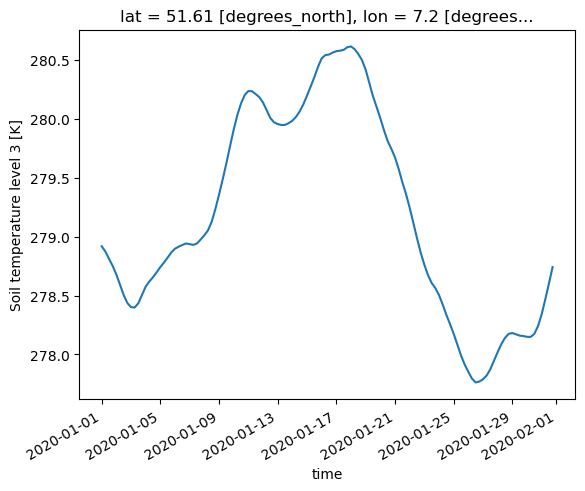

In [14]:
idx = find_nearest_idx(da.isel(time=0).lat.values, da.isel(time=0).lon.values, 51.5, 7.3)
da.isel(x=idx).stl3.plot()

In [4]:
import grib2zarr
import imp
import glob
imp.reload(grib2zarr)

file_list = glob.glob("/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_fc_*.grb")

ds_lst = []
for f in file_list:
    print(f)
    ds = xr.open_dataset(f, engine="cfgrib")
    ds = grib2zarr.preprocess_fc_grib(ds)
    print(f"{list(ds.data_vars)}")
    ds_lst.append(ds)

#da = grib2zarr.open_grib_fc("/ec/res4/scratch/daep/ec_training_db_out/test_i6aj_*_fc_*.grb", idx_arr=da_clim.x.values-1,)# avg_tstep=TIMESTEP)
#da

/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_fc_243.grb
['fal']
/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_fc_8.grb
['sro']
/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_fc_66.grb
['lai_lv']
/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_fc_260038.grb
['snowc']
/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_fc_67.grb
['lai_hv']
/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_fc_167.grb
['t2m']
/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_fc_168.grb
['d2m']
/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_fc_81.grb
['aco2gpp']
/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_fc_182.grb
['e']
/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_fc_9.grb
['ssro']


In [5]:
xr.merge(ds_lst)

<xarray.Dataset>
Dimensions:  (time: 743, x: 654400)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T01:00:00 ... 2020-01-31T23:00:00
    lat      (x) float64 89.83 89.83 89.83 89.83 ... -89.83 -89.83 -89.83 -89.83
    lon      (x) float64 0.0 18.0 36.0 54.0 72.0 ... -72.0 -54.0 -36.0 -18.0
Dimensions without coordinates: x
Data variables:
    fal      (time, x) float32 ...
    sro      (time, x) float32 ...
    lai_lv   (time, x) float32 ...
    snowc    (time, x) float32 ...
    lai_hv   (time, x) float32 ...
    t2m      (time, x) float32 ...
    d2m      (time, x) float32 ...
    aco2gpp  (time, x) float32 ...
    e        (time, x) float32 ...
    ssro     (time, x) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-10-25T19:53 GRIB to CDM+CF via cfgrib-0.9.1...

In [29]:
FC_GLOB_PATTERNS = ["/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_fc_*.grb", "/ec/res4/scratch/daep/ec_training_db_out/i6aj_20191231_fc_*.grb"]
AN_GLOB_PATTERNS = [
    "/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_soil_*.grb",
    "/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101_snow_*.grb",
]

In [30]:
import grib2zarr
import imp
import glob
imp.reload(grib2zarr)

ds_fc_lst = [grib2zarr.open_grib_fc(glob_x) for glob_x in FC_GLOB_PATTERNS]

ds_an_lst = [grib2zarr.open_grib_an(glob_x) for glob_x in AN_GLOB_PATTERNS]

In [33]:
ds_an_lst[0]

<xarray.Dataset>
Dimensions:  (time: 744, x: 654400)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-01-31T23:00:00
    lat      (x) float64 dask.array<chunksize=(654400,), meta=np.ndarray>
    lon      (x) float64 dask.array<chunksize=(654400,), meta=np.ndarray>
Dimensions without coordinates: x
Data variables: (12/13)
    stl1     (time, x) float32 dask.array<chunksize=(744, 654400), meta=np.ndarray>
    sd       (time, x) float32 dask.array<chunksize=(744, 654400), meta=np.ndarray>
    stl2     (time, x) float32 dask.array<chunksize=(744, 654400), meta=np.ndarray>
    stl3     (time, x) float32 dask.array<chunksize=(744, 654400), meta=np.ndarray>
    skt      (time, x) float32 dask.array<chunksize=(744, 654400), meta=np.ndarray>
    stl4     (time, x) float32 dask.array<chunksize=(744, 654400), meta=np.ndarray>
    ...       ...
    fldsto   (time, x) float32 dask.array<chunksize=(744, 654400), meta=np.ndarray>
    rsn      (time, x) float32 dask.array<chunksize=(744, 654400), meta=np.ndarray>
    swvl1    (time, x) float32 dask.array<chunksize=(744, 654400), meta=np.ndarray>
    swvl2    (time, x) float32 dask.array<chunksize=(744, 654400), meta=np.ndarray>
    swvl3    (time, x) float32 dask.array<chunksize=(744, 654400), meta=np.ndarray>
    swvl4    (time, x) float32 dask.array<chunksize=(744, 654400), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-10-25T20:17 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
ds

<xarray.Dataset>
Dimensions:     (latitude: 720, longitude: 1440)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * longitude   (longitude) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    valid_time  datetime64[ns] 2020-03-01
Data variables:
    dis         (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-10-25T18:11 GRIB to CDM+CF via cfgrib-0.9.1...

In [17]:
da = xr.open_mfdataset("/ec/res4/scratch/daep/ec_training_db_out/test_i6aj_20191231_fc_*.grb", engine="cfgrib")
da = da.rename({var: f"met_{var.lower()}" for var in damet.data_vars})

<xarray.Dataset>
Dimensions:     (values: 654400)
Coordinates:
    number      int64 0
    time        datetime64[ns] 2019-12-01
    step        timedelta64[ns] 31 days
    surface     float64 0.0
    latitude    (values) float64 dask.array<chunksize=(654400,), meta=np.ndarray>
    longitude   (values) float64 dask.array<chunksize=(654400,), meta=np.ndarray>
    valid_time  datetime64[ns] 2020-01-01
Dimensions without coordinates: values
Data variables:
    sro         (values) float32 dask.array<chunksize=(654400,), meta=np.ndarray>
    ssro        (values) float32 dask.array<chunksize=(654400,), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-10-25T12:55 GRIB to CDM+CF via cfgrib-0.9.1...

In [23]:
import xarray as xr
damet = xr.open_mfdataset("/ec/res4/scratch/daep/ec_training_db_out/ecland*.zarr", engine="zarr", parallel=True,)
damet = damet.rename({var: f"met_{var.lower()}" for var in damet.data_vars})
damet

<xarray.Dataset>
Dimensions:     (time: 4384, x: 187070)
Coordinates:
    lat         (x) float32 dask.array<chunksize=(187070,), meta=np.ndarray>
    lon         (x) float32 dask.array<chunksize=(187070,), meta=np.ndarray>
  * time        (time) datetime64[ns] 2020-01-01 ... 2022-12-31T18:00:00
  * x           (x) int32 2192 2193 2194 2195 ... 654397 654398 654399 654400
Data variables:
    met_ctpf    (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    met_lwdown  (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    met_psurf   (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    met_qair    (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    met_rainf   (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    met_swdown  (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    met_snowf   (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    met_tair    (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    met_wind_e  (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    met_wind_n  (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
Attributes:
    CONVERTED:     from grib files with grib_api
    GRID_POINTS:  gaussian grid 
    SOURCE:       ECMWF

In [24]:
damod = xr.open_mfdataset("/ec/res4/scratch/daep/ec_training_db_out/i6aj*.zarr", engine="zarr", parallel=True,)
for var in list(damod.data_vars.keys()):
    if var[0] == "0":
        damod = damod.rename({var: var[1:]})
damod

<xarray.Dataset>
Dimensions:      (time: 4384, x: 187070)
Coordinates:
    lat          (x) float64 dask.array<chunksize=(187070,), meta=np.ndarray>
    lon          (x) float64 dask.array<chunksize=(187070,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2020-01-01 ... 2022-12-31T18:00:00
  * x            (x) int32 2192 2193 2194 2195 ... 654397 654398 654399 654400
Data variables: (12/42)
    clim_CLAKE   (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    clim_Ctype   (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    clim_cu      (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    clim_cvh     (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    clim_cvl     (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    clim_geopot  (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    ...           ...
    swvl3        (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    swvl4        (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    t2m          (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    tsn          (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    tsn_l1       (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    tsn_l2       (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2023-10-25T21:05 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [25]:
da_train = xr.merge([damet, damod.drop(["lat", "lon"])])
da_train

<xarray.Dataset>
Dimensions:      (time: 4384, x: 187070)
Coordinates:
    lat          (x) float32 dask.array<chunksize=(187070,), meta=np.ndarray>
    lon          (x) float32 dask.array<chunksize=(187070,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2020-01-01 ... 2022-12-31T18:00:00
  * x            (x) int32 2192 2193 2194 2195 ... 654397 654398 654399 654400
Data variables: (12/52)
    met_ctpf     (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    met_lwdown   (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    met_psurf    (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    met_qair     (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    met_rainf    (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    met_swdown   (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    ...           ...
    swvl3        (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    swvl4        (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    t2m          (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    tsn          (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    tsn_l1       (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
    tsn_l2       (time, x) float32 dask.array<chunksize=(124, 187070), meta=np.ndarray>
Attributes:
    CONVERTED:     from grib files with grib_api
    GRID_POINTS:  gaussian grid 
    SOURCE:       ECMWF

In [28]:
da_train.to_array().sel(time=slice("2020", "2021"))

<xarray.DataArray (variable: 52, time: 2924, x: 187070)>
dask.array<getitem, shape=(52, 2924, 187070), dtype=float32, chunksize=(1, 124, 187070), chunktype=numpy.ndarray>
Coordinates:
    lat       (x) float32 dask.array<chunksize=(187070,), meta=np.ndarray>
    lon       (x) float32 dask.array<chunksize=(187070,), meta=np.ndarray>
  * time      (time) datetime64[ns] 2020-01-01 ... 2021-12-31T18:00:00
  * x         (x) int32 2192 2193 2194 2195 2326 ... 654397 654398 654399 654400
  * variable  (variable) object 'met_ctpf' 'met_lwdown' ... 'tsn_l1' 'tsn_l2'
Attributes:
    CONVERTED:     from grib files with grib_api
    GRID_POINTS:  gaussian grid 
    SOURCE:       ECMWF

In [16]:
var="0clim222"
var[0] == "0"

True

In [12]:
import matplotlib.pyplot as plt
import numpy as np

np.max(abs(damet.lon.values-damod.lon.values)), np.max(abs(damet.lat.values-damod.lat.values))

(4.5730268084298586e-05, 3.7940819339610243e-06)

In [3]:
import xarray as xr
da = xr.open_zarr("/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101.zarr")
da.to_array()

FileNotFoundError: No such file or directory: '/ec/res4/scratch/daep/ec_training_db_out/i6aj_20200101.zarr'